In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Conv2DTranspose,
    Flatten,
    Dense
)
from tensorflow.keras import Sequential, Model
from tensorflow.keras.utils import to_categorical

import os
import random
import tensorflow as tf

%matplotlib inline

Let's configure all random numbers generators to support determinism and obtain reproducible results.

In [2]:
# settings for reproducibility
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

Size of train images: (28, 28), Number of train images: 60000
Size of test images: (28, 28), Number of test images: 10000


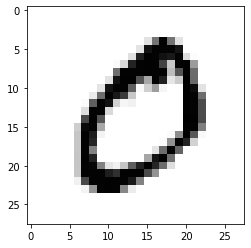

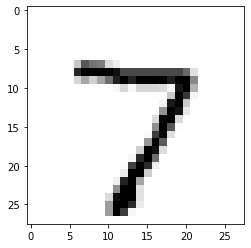

In [3]:
# load mnist dataset
(train_imgs, train_labels), (test_imgs, test_labels) = tf.keras.datasets.mnist.load_data()

# fit image pixel values from 0 to 1
train_imgs, test_imgs = train_imgs / 255.0, test_imgs / 255.0 

# check data array shapes:
print("Size of train images: {}, Number of train images: {}".format(train_imgs.shape[-2:], train_imgs.shape[0]))
print("Size of test images: {}, Number of test images: {}".format(test_imgs.shape[-2:], test_imgs.shape[0]))

# plot image example from training images
plt.imshow(train_imgs[1], cmap='Greys')
plt.show()

# plot image example from test images
plt.imshow(test_imgs[0], cmap='Greys')
plt.show()
plt.close()

In [4]:
# define leaky ReLU function
def lrelu(x, alpha=0.1):
    return tf.math.maximum(alpha*x, x)

In [5]:
# describe encoder pipeline
encoder = Sequential([
    # convolution
    Conv2D(
        filters=32,
        kernel_size=(3,3),
        strides=(1,1),
        padding='SAME',
        use_bias=True,
        activation=lrelu,
        name='conv1'
    ),
    # the input size is 28x28x32
    MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2),
        name='pool1'
    ),
    # the input size is 14x14x32
    Conv2D(
        filters=32,
        kernel_size=(3,3),
        strides=(1,1),
        padding='SAME',
        use_bias=True,
        activation=lrelu,
        name='conv2'
    ),
    # the input size is 14x14x32
    MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2),
        name='encoding'
    )
    # the output size is 7x7x32
])

In [6]:
# describe decoder pipeline
decoder = Sequential([
    Conv2D(
        filters=32,
        kernel_size=(3,3),
        strides=(1,1),
        name='conv3',
        padding='SAME',
        use_bias=True,
        activation=lrelu
    ),
    # updampling, the input size is 7x7x32
    Conv2DTranspose(
        filters=32,
        kernel_size=3,
        padding='same',
        strides=2,
        name='upsample1'
    ),
    # upsampling, the input size is 14x14x32
    Conv2DTranspose(
        filters=32,
        kernel_size=3,
        padding='same',
        strides=2,
        name='upsample2'
    ),
    # the input size is 28x28x32
    Conv2D(
        filters=1,
        kernel_size=(3,3),
        strides=(1,1),
        name='logits',
        padding='SAME',
        use_bias=True
    )    
])

In [7]:
# model class definition
class EncoderDecoderModel(Model):
    def __init__(self, is_sigmoid=False):
        super(EncoderDecoderModel, self).__init__()
        # assign encoder sequence
        self._encoder = encoder
        # assign decoder sequence 
        self._decoder = decoder
        self._is_sigmoid = is_sigmoid
        
    # forward pass
    def call(self, x):
        x = self._encoder(x)
        decoded = self._decoder(x)
        if self._is_sigmoid:
            decoded = tf.keras.activations.sigmoid(decoded)
        return decoded

Prepare input data for the model:

In [8]:
# add noise to the images for train and test
def distort_image(input_imgs, noise_factor=0.5):
    noisy_imgs = input_imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=input_imgs.shape) 
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

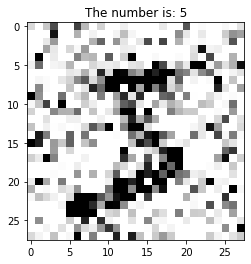

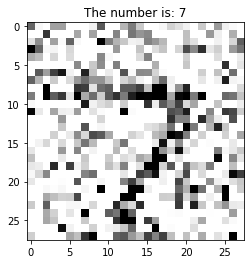

In [9]:
# prepare training reference images: add new dimension
train_imgs_data = train_imgs[..., tf.newaxis]

# prepare test reference images: add new dimension
test_imgs_data = test_imgs[..., tf.newaxis]

# prepare distorted input data for training
train_noisy_imgs = distort_image(train_imgs_data)

# prepare distorted input data for evaluation
test_noisy_imgs = distort_image(test_imgs_data)

# plot distorted image example from training images
image_id_to_plot = 0
plt.imshow(tf.squeeze(train_noisy_imgs[image_id_to_plot]), cmap='Greys')
plt.title("The number is: {}".format(train_labels[image_id_to_plot]))
plt.show()

# plot distorted image example from test images
plt.imshow(tf.squeeze(test_noisy_imgs[image_id_to_plot]), cmap='Greys')
plt.title("The number is: {}".format(test_labels[image_id_to_plot]))
plt.show()
plt.close()

In [10]:
# define custom target function for further minimization
def cost_function(labels=None, logits=None, name=None):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits, name=name)
    return tf.reduce_mean(loss) 

In [11]:
# funstion for train and val losses visualizations
def plot_losses(results):
    plt.plot(results.history['loss'], 'bo', label='Training loss')
    plt.plot(results.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and validation loss',fontsize=14)
    plt.xlabel('Epochs ',fontsize=14)
    plt.ylabel('Loss',fontsize=14)
    plt.legend()
    plt.show()
    plt.close()

The following block describes basic training pipeline:

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 8s 130us/sample - loss: 0.5725 - val_loss: 0.4929
Epoch 2/25
60000/60000 [==============================] - 6s 93us/sample - loss: 0.4393 - val_loss: 0.3462
Epoch 3/25
60000/60000 [==============================] - 6s 93us/sample - loss: 0.2448 - val_loss: 0.2063
Epoch 4/25
60000/60000 [==============================] - 6s 92us/sample - loss: 0.1895 - val_loss: 0.1741
Epoch 5/25
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1671 - val_loss: 0.1590
Epoch 6/25
60000/60000 [==============================] - 6s 93us/sample - loss: 0.1548 - val_loss: 0.1485
Epoch 7/25
60000/60000 [==============================] - 5s 91us/sample - loss: 0.1457 - val_loss: 0.1407
Epoch 8/25
60000/60000 [==============================] - 5s 91us/sample - loss: 0.1389 - val_loss: 0.1349
Epoch 9/25
60000/60000 [==============================] - 5s 91us/sample - loss: 0.1342 - val

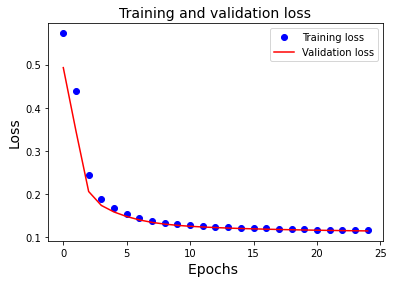

In [12]:
# instantiate the model
encoder_decoder_model = EncoderDecoderModel()

# training loop params
num_epochs = 25
batch_size_to_set = 64

# training process params
learning_rate = 1e-5
# default number of workers for training process
num_workers = 2

# initialize the training configurations such as optimizer, loss function and accuracy metrics
encoder_decoder_model.compile(
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
    loss=cost_function,
    metrics=None
)

results = encoder_decoder_model.fit(
    train_noisy_imgs,
    train_imgs_data,
    epochs=num_epochs,
    batch_size=batch_size_to_set,
    validation_data=(test_noisy_imgs, test_imgs_data),
    workers=num_workers,
    shuffle=True
)

# visualize train and val losses
plot_losses(results)

Let's view the decoding process on the same data:

In [13]:
# instantiate the model with final sigmoid activation
encoder_decoder_model2 = EncoderDecoderModel(is_sigmoid=True)

# define the number of images to decode
img_num_to_decode = 10

# get 10 test reference images
test_imgs_data_decode = test_imgs_data[:img_num_to_decode]

# get 10 distorted input test data and cast to float32 as tf layer's dtype is float32
test_noisy_imgs_decode = tf.cast(test_noisy_imgs[:img_num_to_decode], tf.float32)

decoded_images = encoder_decoder_model2(test_noisy_imgs_decode)

Original Images


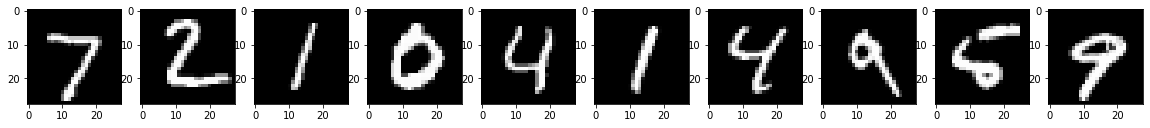

Noisy Images


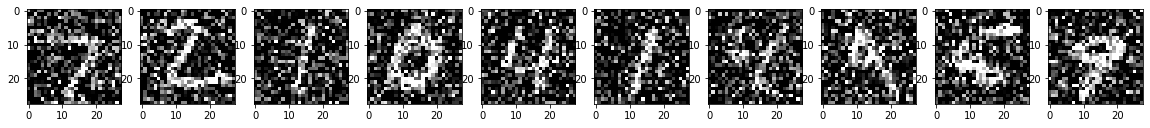

Reconstruction of Noisy Images


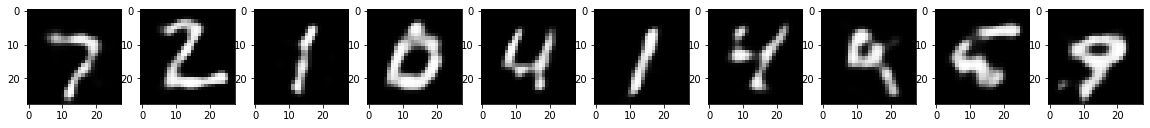

In [14]:
# view initial, noisy and decoded images
plt.figure(figsize=(20, 4))
plt.title('Reconstructed Images')

print("Original Images")
for i in range(img_num_to_decode):
    plt.subplot(2, img_num_to_decode, i+1)
    plt.imshow(test_imgs_data_decode[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))

# plot the range of input noisy images
print("Noisy Images")
for i in range(img_num_to_decode):
    plt.subplot(2, img_num_to_decode, i+1)
    plt.imshow(test_noisy_imgs_decode[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))

# plot the range of decoded noisy images
print("Reconstruction of Noisy Images")
for i in range(img_num_to_decode):
    plt.subplot(2, img_num_to_decode, i+1)
    plt.imshow(decoded_images[i, ..., 0], cmap='gray')    
plt.show()    
plt.close()  